# Model Fit in Linear Regression - Lab

## Introduction
In this lab, you'll learn how to evaluate your model results, and you'll learn methods to select the appropriate features using stepwise selection.

## Objectives
You will be able to:
* Analyze the results of regression and R-squared and adjusted-R-squared 
* Understand and apply forward and backward predictor selection

## The Boston Housing Data once more

We pre-processed the Boston Housing Data the same way we did before:

- We dropped "ZN" and "NOX" completely
- We categorized "RAD" in 3 bins and "TAX" in 4 bins
- We used min-max-scaling on "B", "CRIM" and "DIS" (and logtransformed all of them first, except "B")
- We used standardization on "AGE", "INDUS", "LSTAT" and "PTRATIO" (and logtransformed all of them first, except for "AGE") 

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
boston = load_boston()

boston_features = pd.DataFrame(boston.data, columns = boston.feature_names)
boston_features = boston_features.drop(["NOX","ZN"],axis=1)

# first, create bins for based on the values observed. 3 values will result in 2 bins
bins = [0,6,  24]
bins_rad = pd.cut(boston_features['RAD'], bins)
bins_rad = bins_rad.cat.as_unordered()

# first, create bins for based on the values observed. 4 values will result in 3 bins
bins = [0, 270, 360, 712]
bins_tax = pd.cut(boston_features['TAX'], bins)
bins_tax = bins_tax.cat.as_unordered()

tax_dummy = pd.get_dummies(bins_tax, prefix="TAX")
rad_dummy = pd.get_dummies(bins_rad, prefix="RAD")
boston_features = boston_features.drop(["RAD","TAX"], axis=1)
boston_features = pd.concat([boston_features, rad_dummy, tax_dummy], axis=1)

age = boston_features["AGE"]
b = boston_features["B"]
logcrim = np.log(boston_features["CRIM"])
logdis = np.log(boston_features["DIS"])
logindus = np.log(boston_features["INDUS"])
loglstat = np.log(boston_features["LSTAT"])
logptratio = np.log(boston_features["PTRATIO"])

# minmax scaling
boston_features["B"] = (b-min(b))/(max(b)-min(b))
boston_features["CRIM"] = (logcrim-min(logcrim))/(max(logcrim)-min(logcrim))
boston_features["DIS"] = (logdis-min(logdis))/(max(logdis)-min(logdis))

#standardization
boston_features["AGE"] = (age-np.mean(age))/np.sqrt(np.var(age))
boston_features["INDUS"] = (logindus-np.mean(logindus))/np.sqrt(np.var(logindus))
boston_features["LSTAT"] = (loglstat-np.mean(loglstat))/np.sqrt(np.var(loglstat))
boston_features["PTRATIO"] = (logptratio-np.mean(logptratio))/(np.sqrt(np.var(logptratio)))

## Perform stepwise selection

The code for stepwise selection is copied below.

In [2]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [19]:
predictors = boston_features.drop("CRIM", axis = 1)
y = boston_features["CRIM"]
initial_list1 = list(X.columns)
feature_list = stepwise_selection(predictors, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True)

Add  DIS                            with p-value 2.82884e-90
Add  RAD_(6, 24]                    with p-value 6.953e-72
Add  RAD_(0, 6]                     with p-value 1.4733e-51
Add  INDUS                          with p-value 2.24098e-21
Add  B                              with p-value 3.07968e-09
Add  LSTAT                          with p-value 1.90996e-06
Add  TAX_(0, 270]                   with p-value 0.00039981


### Build the final model again in Statsmodels

In [20]:
import statsmodels.api as sm
final_model = sm.OLS(boston_features["CRIM"],sm.add_constant(boston_features[feature_list])).fit()

In [21]:
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   CRIM   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     403.3
Date:                Sun, 05 May 2019   Prob (F-statistic):          8.86e-188
Time:                        19:36:04   Log-Likelihood:                 481.17
No. Observations:                 506   AIC:                            -948.3
Df Residuals:                     499   BIC:                            -918.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4907      0.014     33.908      0.000       0.462       0.519
DIS             -0.3372      0.028    -12.006      0.000      -0.392      -0.282
RAD_(6, 24]      0.3421      0.008     43.309      0.000       0.327       0.358
RAD_(0, 6]       0.1486      0.010     15.236      0.000       0.129       0.168
INDUS            0.0430      0.007      6.051      0.000       0.029       0.057
B               -0.1081      0.020     -5.322      0.000      -0.148      -0.068
LSTAT            0.0243      0.005      4.426      0.000       0.014       0.035
TAX_(0, 270]    -0.0428      0.012     -3.564      0.000      -0.066      -0.019
==============================================================================
Omnibus:                        4.253   Durbin-Watson:                   0.548
Prob(Omnibus):                  0.119   Jarque-Bera (JB):                4.311
Skew:                          -0.223   Prob(JB):                        0.116
Kurtosis:                       2.921   Cond. No.                     2.95e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.57e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Where our stepwise procedure mentions that "CHAS" was added with a p-value of 0.00151282, but our statsmodels output returns a p-value of 0.000. What is the intuition behind this?

## Use Feature ranking with recursive feature elimination

Use feature ranking to select the 5 most important features

In [22]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 2)
selector = selector.fit(predictors, y)

In [23]:
selector.support_ 

array([False, False, False, False,  True, False, False, False, False,
        True, False, False, False])

In [24]:
selector.ranking_

array([ 4,  9, 11,  8,  1, 10,  2,  6,  3,  1,  5, 12,  7])

In [ ]:
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

Fit the linear regression model again using the 5 columns selected

In [33]:
sk_model = LinearRegression()
predictors_sk = boston_features.loc[:,selector.support_ ]
sk_model.fit(predictors_sk,boston_features.CRIM)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Now, predict $\hat y$ using your model. you can use `.predict()` in scikit-learn

In [35]:
sk_predictions = sk_model.predict(predictors_sk)

/opt/conda/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


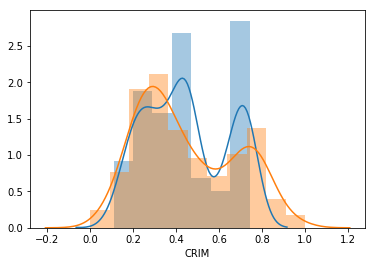

In [38]:
import seaborn as sns
sns.distplot(sk_predictions)
sns.distplot(boston_features["CRIM"])

Now, using the formulas of R-squared and adjusted-R-squared below, and your Python/numpy knowledge, compute them and contrast them with the R-squared and adjusted-R-squared in your statsmodels output using stepwise selection. Which of the two models would you prefer?

$SS_{residual} = \sum (y - \hat{y})^2 $

$SS_{total} = \sum (y - \bar{y})^2 $

$R^2 = 1- \dfrac{SS_{residual}}{SS_{total}}$

$R^2_{adj}= 1-(1-R^2)\dfrac{n-1}{n-p-1}$

## Level up - Optional

- Perform variable selection using forward selection, using this resource: https://planspace.org/20150423-forward_selection_with_statsmodels/. Note that this time features are added based on the adjusted-R-squared!
- Tweak the code in the `stepwise_selection()`-function written above to just perform forward selection based on the p-value.

## Summary
Great! You now performed your own feature selection methods!